In [1]:
from pandas_datareader import data as pdr
import pandas as pd
from datetime import date
import yfinance as yf
yf.pdr_override()
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt

# Tickers list
ticker_list=['AAPL', 'MA', 'V', 'MSFT', 'BAC', 'JPM', 'NFLX', 'SCI', 'AAXN']

# Dates
today = date.today()
start_date = '2016-1-1'
end_date = '2020-1-1'

def SaveData(df, filename):
    df.to_csv(r'data/'+filename+'.csv')
    
def GetData(ticker_list):
    print(ticker_list)
    df=[]
    for ticker in ticker_list:
        #print(ticker)
        data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date, progress=False)
        data['Symbol'] = ticker 
        df.append(data)
    print("Data Download Completed")
    return df

def SaveFig(filename):
    plt.savefig(r'fig/'+filename)

In [2]:
# Get the Data
df = GetData(ticker_list)
df = pd.concat(df)
df = df.reset_index()
df = df[['Date', 'Adj Close', 'Symbol']]
stocks = df.pivot('Date','Symbol','Adj Close').reset_index()
SaveData(stocks,str(start_date)+'|'+str(end_date))

['AAPL', 'MA', 'V', 'MSFT', 'BAC', 'JPM', 'NFLX', 'SCI', 'AAXN']
Data Download Completed


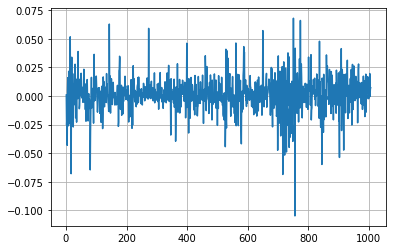

In [3]:
# Useful data
returns = np.log(stocks[ticker_list]/stocks[ticker_list].shift(1))
returns.insert(0,'Date',stocks['Date'])
mean_returns = returns.mean()
covariance = returns.cov()

# Risk-free Treasury bills 13 months 
risk_free_rate = 0.0178

plt.plot(returns['AAPL'])
plt.grid()

In [4]:
# Useful functions
def portfolio_annualized_perf(weights):
    returns = (np.sum(mean_returns*weights))*252
    std = np.sqrt(np.dot(weights.T,np.dot(covariance,weights)))*np.sqrt(252)
    sharpe = (returns-risk_free_rate)/std
    return [returns,std,sharpe]

def neg_sharpe(weights):
    return portfolio_annualized_perf(weights)[2] * -1

def check_sum(weights):
    return np.sum(weights)-1

def check_psum(weights):
    return sum(w for w in weights if w > 0)-1

def check_nsum(weights,limit): # Limit in [0,1]
    return sum(w for w in weights if w < 0)+limit

def std(weights):
    return portfolio_annualized_perf(weights)[1]

def short_port_correct(weights, limit = 100):
    limit = limit/100
    p_weights = sum(w for w in weights if w > 0)
    n_weights = sum(w for w in weights if w < 0) * -1
    for i, w in enumerate(weights):
        if(w > 0):
            weights[i] = weights[i]/p_weights
        else:
            weights[i] = (weights[i] * limit)/n_weights
    return weights

def minimize_std(obj_return, short=False, limit=100):
    if(short):
        limit = limit/100 # max limit % of budget in short positions
        bounds = [(-1,1)] * len(ticker_list) 
        cons = ({'type':'eq', 'fun':check_psum},
                {'type':'eq', 'fun': lambda w: check_nsum(w, limit=limit)},
                {'type':'eq', 'fun': lambda w: portfolio_annualized_perf(w)[0] - obj_return})     
    else:
        bounds = [(0,1)] * len(ticker_list) # no short position
        cons = ({'type':'eq', 'fun':check_sum},
                {'type':'eq', 'fun': lambda w: portfolio_annualized_perf(w)[0] - obj_return})       
    init_guess = [1/len(ticker_list)] * len(ticker_list)
    result = minimize(std, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    return result['fun']

def maximize_sharpe(short=False, limit=100):
    if(short):
        limit = limit/100 # max limit % of budget in short positions
        bounds = [(-1,1)] * len(ticker_list)
        cons = ({'type':'eq', 'fun':check_psum},
                {'type':'eq', 'fun': lambda w: check_nsum(w, limit=limit)})
    else:
        bounds = [(0,1)] * len(ticker_list) # no short position
        cons = ({'type':'eq', 'fun':check_sum},)
    init_guess = [1/len(ticker_list)] * len(ticker_list)
    result = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    return result['fun'] * -1

def display_portfolio(weights):
    perf = portfolio_annualized_perf(weights)
    print('Annualized forecasted returns :'+str(round(perf[0]*100,2))+'%')
    print('Annualized forecasted standard deviation :'+str(round(perf[1]*100,2))+'%')
    print('Sharpe Ratio:'+str((round(perf[2],2))))
    print('')
    port_perc = pd.DataFrame({'Symbol': ticker_list, '%': list(np.round(weights*100,2))})
    print(port_perc.to_string(index=False))

In [5]:
# Portfolios simulation with no short positions
#np.random.seed(42)
num_ports = 20000

port_list = []
port_perf = pd.DataFrame(columns = ['Returns','Std','Sharpe'])

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(ticker_list)))
    weights = weights/np.sum(weights)
    # Save weights and performance
    port_list.append(weights)
    port_perf.loc[len(port_perf.index)]=portfolio_annualized_perf(weights)

# Max sharpe ratio portfolio
max_port = port_list[port_perf['Sharpe'].idxmax()]
max_sr_ret, max_sr_vol, max_sr = portfolio_annualized_perf(max_port)

# Min variance portfolio
min_port = port_list[port_perf['Std'].idxmin()]
min_std_ret, min_std, min_std_sr = portfolio_annualized_perf(min_port)

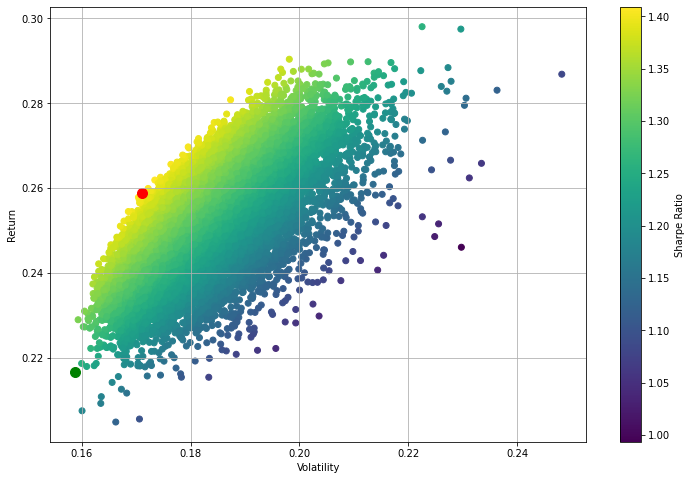

In [6]:
# Plot of all portfolios
plt.figure(figsize=(12,8))
plt.scatter(port_perf['Std'], port_perf['Returns'], c=port_perf['Sharpe'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=100) # max sharpe ratio
plt.scatter(min_std, min_std_ret,c='green', s=100) # min std 
plt.grid()
plt.show()

In [7]:
# Mean-Variance analysis with no short positions
frontier_y = np.linspace(port_perf['Returns'].min(), port_perf['Returns'].max(),200)
frontier_x = []

for obj_return in frontier_y:
    frontier_x.append(minimize_std(obj_return))

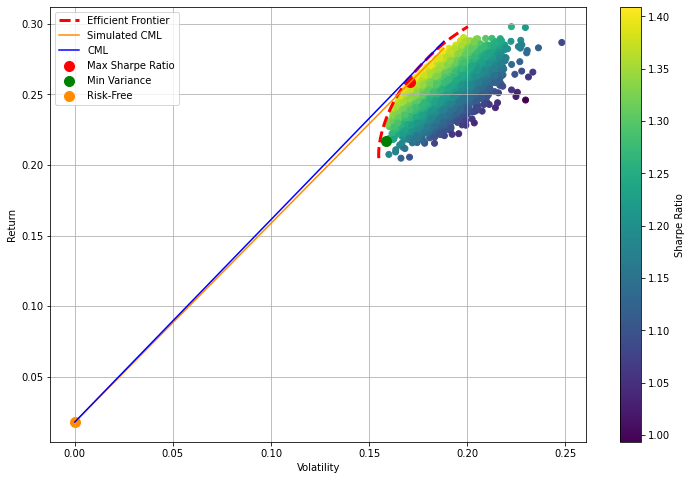

In [8]:
# Plot efficient frontier and CML
plt.figure(figsize=(12,8))
plt.scatter(port_perf['Std'], port_perf['Returns'], c=port_perf['Sharpe'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(frontier_x,frontier_y, 'r--', linewidth=3, label='Efficient Frontier')

plt.scatter(max_sr_vol, max_sr_ret,c='red', s=100, label='Max Sharpe Ratio') # max sharpe ratio
plt.scatter(min_std, min_std_ret,c='green', s=100, label='Min Variance') # min std
plt.scatter(0, risk_free_rate,c='darkorange', s=100, label='Risk-Free') # risk free asset

x = np.linspace(0,max_sr_vol * 1.1,100)

y = max_sr * x + risk_free_rate
plt.plot(x, y, color='darkorange', label='Simulated CML')

y = maximize_sharpe() * x + risk_free_rate
plt.plot(x, y, color='blue', label='CML')

plt.legend()
plt.grid()
SaveFig('EF-CML-NoShort|'+str(start_date)+'|'+str(end_date))
plt.show()

In [9]:
display_portfolio(max_port)

Annualized forecasted returns :25.87%
Annualized forecasted standard deviation :17.1%
Sharpe Ratio:1.41

Symbol      %
  AAPL  18.06
    MA  26.52
     V   4.88
  MSFT  13.16
   BAC   0.65
   JPM  20.36
  NFLX   0.91
   SCI   9.24
  AAXN   6.21


In [10]:
# Portfolios simulation with short positions
limit = 25 # Limit on the short budget
np.random.seed(42)
num_ports = 20000

port_list = []
port_perf = pd.DataFrame(columns = ['Returns','Std','Sharpe'])

for x in range(num_ports):
    # Weights with short limit in %
    weights = 2*np.array(np.random.random(len(ticker_list)))-1
    weights = short_port_correct(weights, limit)
    # Save weights and performance
    port_list.append(weights)
    port_perf.loc[len(port_perf.index)]=portfolio_annualized_perf(weights)

# Max sharpe ratio portfolio
max_port = port_list[port_perf['Sharpe'].idxmax()]
max_sr_ret, max_sr_vol, max_sr = portfolio_annualized_perf(max_port)

# Min variance portfolio
min_port = port_list[port_perf['Std'].idxmin()]
min_std_ret, min_std, min_std_sr = portfolio_annualized_perf(min_port)

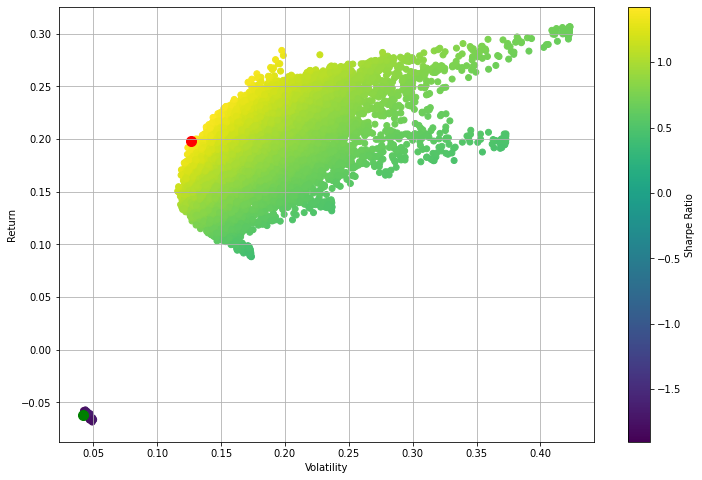

In [11]:
# Plot of all portfolios
plt.figure(figsize=(12,8))
plt.scatter(port_perf['Std'], port_perf['Returns'], c=port_perf['Sharpe'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=100) # max sharpe ratio
plt.scatter(min_std, min_std_ret,c='green', s=100) # min std 
plt.grid()
plt.show()

In [12]:
# Mean-Variance analysis with short positions
frontier_y = np.linspace(port_perf['Returns'].min(), port_perf['Returns'].max(),200)
frontier_x = []

for obj_return in frontier_y:
    frontier_x.append(minimize_std(obj_return, short=True, limit=limit))   

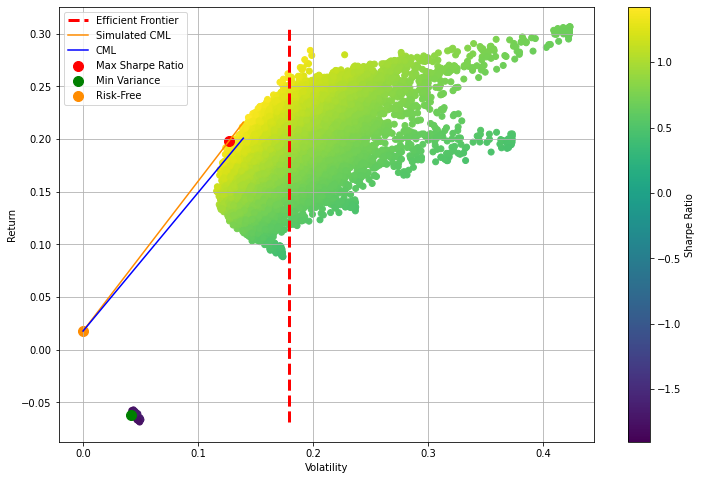

In [13]:
# Plot efficient frontier and CML
plt.figure(figsize=(12,8))
plt.scatter(port_perf['Std'], port_perf['Returns'], c=port_perf['Sharpe'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(frontier_x,frontier_y, 'r--', linewidth=3, label='Efficient Frontier')

plt.scatter(max_sr_vol, max_sr_ret,c='red', s=100, label='Max Sharpe Ratio') # max sharpe ratio
plt.scatter(min_std, min_std_ret,c='green', s=100, label='Min Variance') # min std
plt.scatter(0, risk_free_rate,c='darkorange', s=100, label='Risk-Free') # risk free asset

x = np.linspace(0,max_sr_vol * 1.1,100)

y = max_sr * x + risk_free_rate
plt.plot(x, y, color='darkorange', label='Simulated CML')

y = maximize_sharpe(short=True) * x + risk_free_rate
plt.plot(x, y, color='blue', label='CML')

plt.legend()
plt.grid()
SaveFig('EF-CML-Short|'+str(start_date)+'|'+str(end_date))
plt.show()

In [14]:
display_portfolio(max_port)

Annualized forecasted returns :19.79%
Annualized forecasted standard deviation :12.66%
Sharpe Ratio:1.42

Symbol      %
  AAPL  16.24
    MA  15.57
     V  -0.60
  MSFT  18.71
   BAC -23.55
   JPM  41.18
  NFLX  -0.85
   SCI   5.59
  AAXN   2.71
